In [1]:
# !pip install h5py
# !pip install pandas matplotlib
# !pip install seaborn
# !pip install scipy
# !pip install scikit-learn

In [2]:
import torch
from model.model_3D import *
from model.train_eval import *
import copy
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import h5py
from postprocessing.save_results import *
from postprocessing.plot_results import *
from postprocessing.metrics import single_roc_curve

In [3]:
### check if cuda is available

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using {device}.")

Using cuda.


In [4]:
### import data

def load_with_hdf5(name):
    """
    Load tensor data from HDF5 with gzip compression
    """
    with h5py.File(f"data/{name}.h5", "r") as f:
        loaded_features = torch.from_numpy(f["features"][:])
        loaded_labels = torch.from_numpy(f["labels"][:])
    return TensorDataset(loaded_features, loaded_labels)

train_set = load_with_hdf5("train_set_3d")
val_set = load_with_hdf5("val_set_3d")
test_set = load_with_hdf5("test_set_3d")


In [5]:
train_set = TensorDataset(train_set.tensors[0], train_set.tensors[1].squeeze())
val_set = TensorDataset(val_set.tensors[0], val_set.tensors[1].squeeze())
test_set = TensorDataset(test_set.tensors[0], test_set.tensors[1].squeeze())

In [6]:
print(f"Train set: {len(train_set)} samples")
print(f"Validation set: {len(val_set)} samples")
print(f"Test set: {len(test_set)} samples")

Train set: 518 samples
Validation set: 19 samples
Test set: 19 samples


In [12]:
train_set[0][0].shape[0]

1

In [13]:
n_channels = train_set[0][0].shape[0]
n_classes = 1 # ?
init_hid_dim = 8
kernel_size = 3
pooling = 'max'

model = UNet3D(n_channels=n_channels,
               n_classes=n_classes,
               init_hid_dim=init_hid_dim,
               kernel_size=kernel_size,
               pooling=pooling,
               bilinear=False,
               drop_channels=False)

In [8]:
model

UNet3D(
  (temporal_conv): TemporalConv(
    (conv3d): Conv3d(1, 8, kernel_size=(4, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
    (relu): ReLU(inplace=True)
  )
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), paddi

In [9]:
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters:.2e}.")
model_size_MB = num_parameters * 4 / 1024 / 1024 # assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB.")

Number of parameters: 4.87e+05.
Model size: 1.86 MB.


In [10]:
learning_rate = 0.05
batch_size = 16
num_epochs = 100
water_threshold = 0.5

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

step_size = 15
gamma = 0.75

if (step_size and gamma) is not None:
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [11]:
# from torchviz import make_dot

# batch = next(iter(train_loader))
# yhat = model(batch[0]) # Give dummy batch to forward().

# make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz_3d", format="png")

In [12]:
# initialize training, validation losses and metrics
train_losses, val_losses = [], []
accuracies, precisions, recalls, f1_scores, csi_scores = [], [], [], [], []

# set classification loss - possible options: 'BCE', 'BCE_Logits', and 'Focal'
loss_f = 'BCE' 

for epoch in range(1, num_epochs+1):
    
    # model training
    train_loss = training_unet(model, train_loader, optimizer, water_threshold=water_threshold, 
                               device=device, loss_f=loss_f)
    
    # update learning rate
    if (step_size and gamma) is not None:
        scheduler.step() # update the learning rate

    # model validation
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_csi_score = validation_unet(model, val_loader, 
                                                                                                     device=device, loss_f=loss_f, 
                                                                                                     water_threshold=water_threshold)
    if epoch == 1:
        best_loss = val_loss
        best_recall = val_recall
    
    # save model with min val loss
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0
    # save model with max recall
    if val_recall>=best_recall:
        best_model_recall = copy.deepcopy(model)
        best_recall = val_recall
        best_epoch = epoch
        count = 0


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_accuracy)
    precisions.append(val_precision)
    recalls.append(val_recall)
    f1_scores.append(val_f1_score)
    csi_scores.append(val_csi_score)

    count += 1
    
    if epoch%1 == 0:
        print(f"Epoch: {epoch} | " +
              f"Training loss: {train_loss:.2e}, Validation loss: {val_loss:.2e}, Best validation loss: {best_loss:.2e} " + 
              f" | Metrics: Accuracy: {val_accuracy:.3f}, Precision: {val_precision:.3f}, Recall: {val_recall:.3f},\
 F1-score: {val_f1_score:.3f}, CSI-score: {val_csi_score:.3f}, Best recall: {best_recall:.3f}")
        if (step_size and gamma) is not None:
            print(f'Current learning rate: {scheduler.get_last_lr()[0]}')

Epoch: 1 | Training loss: 2.15e-01, Validation loss: 4.75e+00, Best validation loss: 4.75e+00  | Metrics: Accuracy: 0.890, Precision: 0.346, Recall: 0.061, F1-score: 0.103, CSI-score: 0.055, Best recall: 0.061
Current learning rate: 0.05
Epoch: 2 | Training loss: 1.77e-01, Validation loss: 2.65e-01, Best validation loss: 2.65e-01  | Metrics: Accuracy: 0.921, Precision: 0.605, Recall: 0.711, F1-score: 0.654, CSI-score: 0.486, Best recall: 0.711
Current learning rate: 0.05
Epoch: 3 | Training loss: 1.73e-01, Validation loss: 1.56e-01, Best validation loss: 1.56e-01  | Metrics: Accuracy: 0.929, Precision: 0.681, Recall: 0.608, F1-score: 0.642, CSI-score: 0.473, Best recall: 0.711
Current learning rate: 0.05
Epoch: 4 | Training loss: 1.72e-01, Validation loss: 1.53e-01, Best validation loss: 1.53e-01  | Metrics: Accuracy: 0.930, Precision: 0.703, Recall: 0.580, F1-score: 0.636, CSI-score: 0.466, Best recall: 0.711
Current learning rate: 0.05
Epoch: 5 | Training loss: 1.72e-01, Validation l

In [13]:
metrics = [accuracies, precisions, recalls, f1_scores, csi_scores]

In [14]:
# store training and validation losses and metrics to be stored in a .csv file for later postprocessing
# always check the dataset month key

save_losses_metrics(train_losses, val_losses, metrics, 'spatial', model, 3, init_hid_dim, 
                    kernel_size, pooling, learning_rate, step_size, gamma, batch_size, num_epochs, 
                    water_threshold)

model/losses_metrics/UNet3D_spatial_losses&metrics_month3_4dwns_32ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.csv


In [15]:
# save model with max recall
# always check the dataset month key

save_model_path(best_model_recall, 'spatial', 'recall', 3, init_hid_dim, kernel_size, pooling, learning_rate, 
                step_size, gamma, batch_size, num_epochs, water_threshold) 

model/models_trained/UNet3D_brecall_spatial_month3_4dwns_32ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.pth


In [16]:
# test the min loss model - average loss and metrics

model_loss = copy.deepcopy(best_model)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_csi_score = validation_unet(model_loss, test_loader, device=device, loss_f = loss_f)

print(f'Average metrics for test dataset using model with best validation loss:\n\n\
{loss_f} loss:          {test_loss:.3e}\n\
Accuracy:          {test_accuracy:.3f}\n\
Precision:         {test_precision:.3f}\n\
Recall:            {test_recall:.3f}\n\
F1 score:          {test_f1_score:.3f}\n\
CSI score:         {test_csi_score:.3f}')

Average metrics for test dataset using model with best validation loss:

BCE loss:          1.404e-01
Accuracy:          0.936
Precision:         0.740
Recall:            0.685
F1 score:          0.712
CSI score:         0.552


In [17]:
# test the max recall model - average loss and metrics

model_recall = copy.deepcopy(best_model_recall)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_csi_score = validation_unet(model_recall, test_loader, device=device, loss_f = loss_f)

print(f'Average metrics for test dataset using model with best validation recall:\n\n\
{loss_f} loss:          {test_loss:.3e}\n\
Accuracy:          {test_accuracy:.3f}\n\
Precision:         {test_precision:.3f}\n\
Recall:            {test_recall:.3f}\n\
F1 score:          {test_f1_score:.3f}\n\
CSI score:         {test_csi_score:.3f}')

Average metrics for test dataset using model with best validation recall:

BCE loss:          1.576e-01
Accuracy:          0.929
Precision:         0.646
Recall:            0.837
F1 score:          0.729
CSI score:         0.574


ATTENTION: the argument `save_name` is not specified: the plot is not saved.


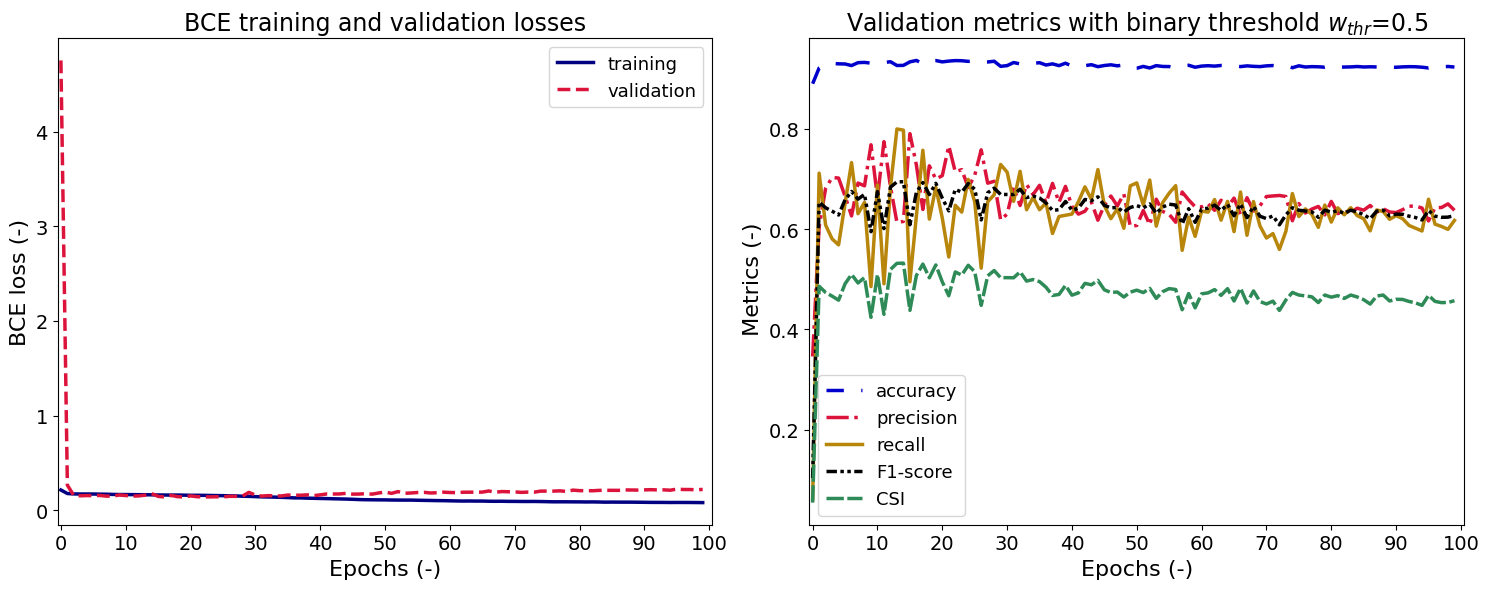

In [18]:
plot_losses_metrics(train_losses, val_losses, metrics, model_recall, loss_f=loss_f)

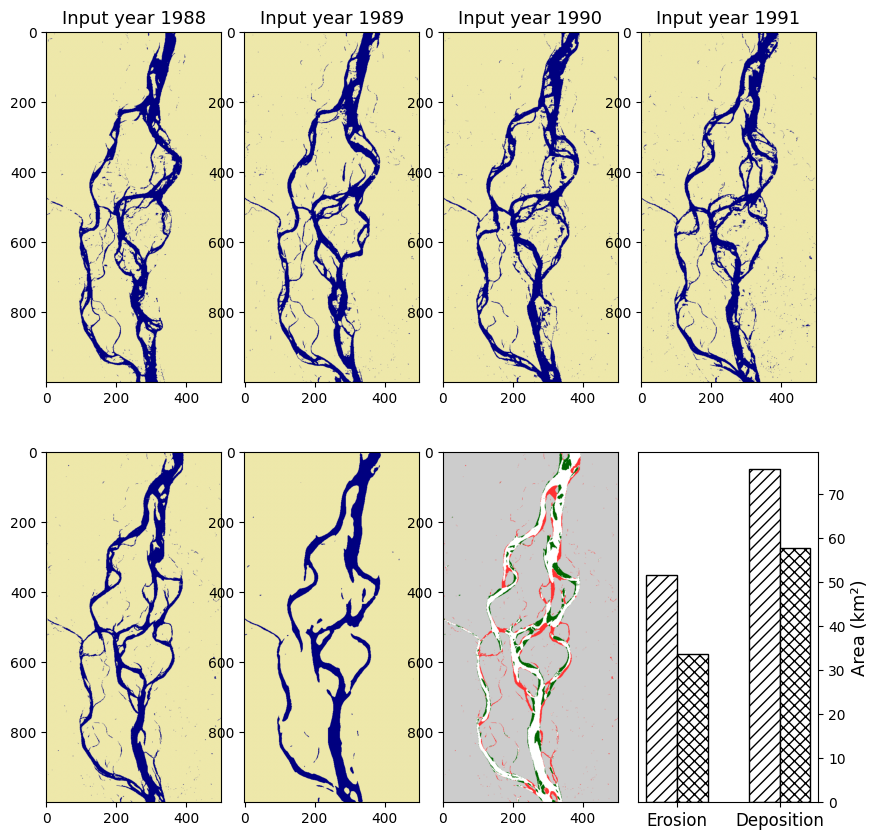

In [19]:
show_evolution_nolegend_3d(18, test_set, model_loss)

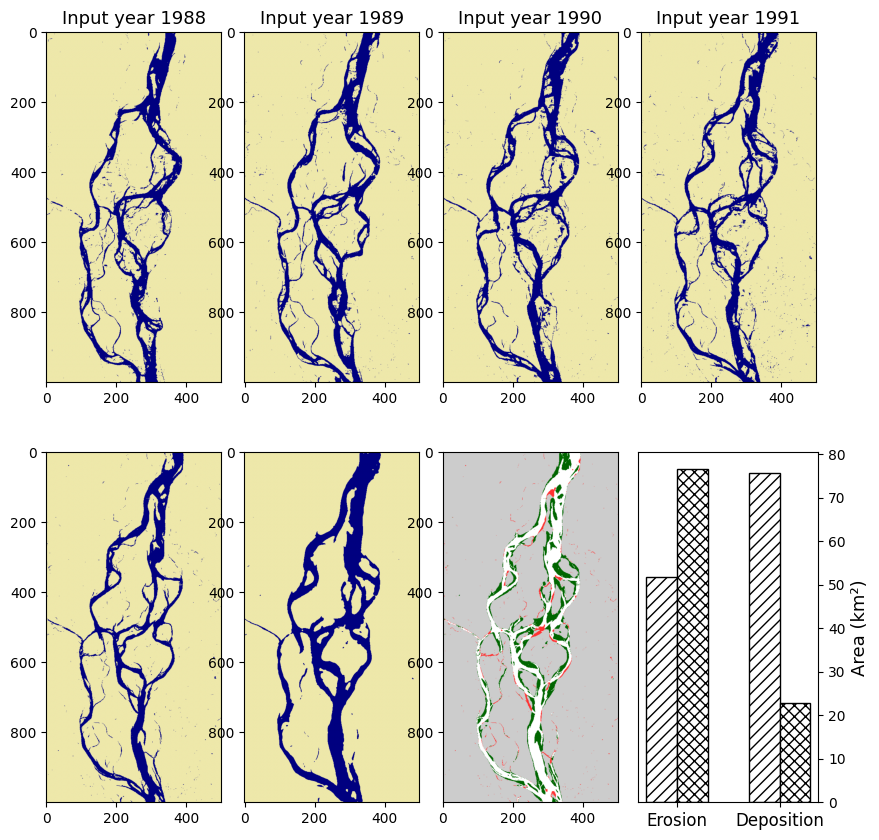

In [20]:
show_evolution_nolegend_3d(18, test_set, model_recall)

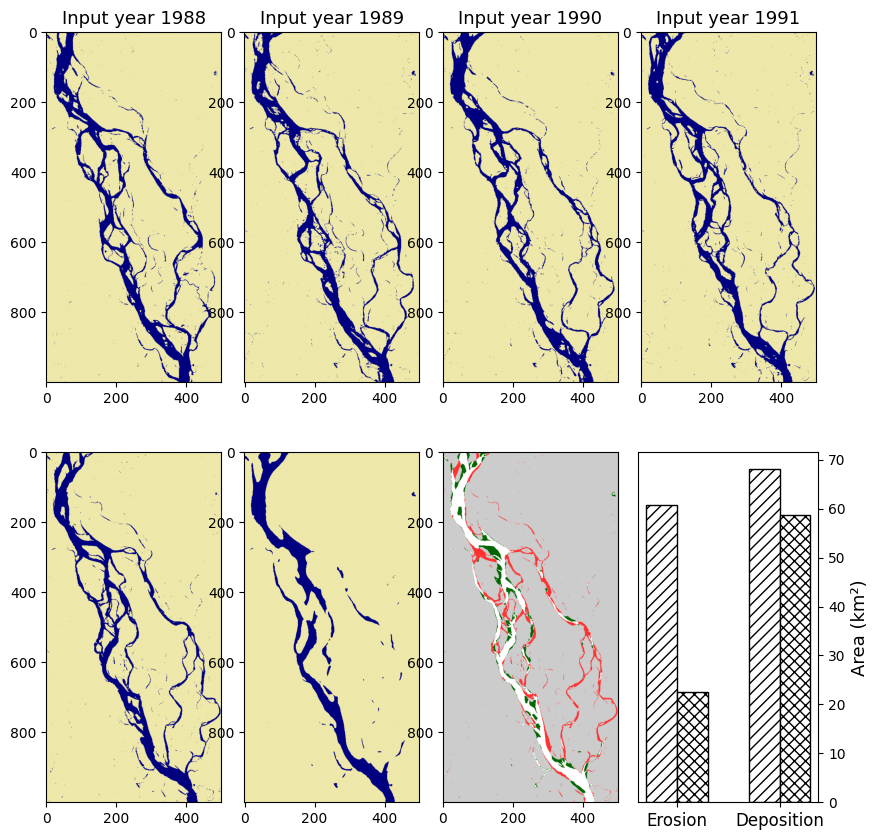

In [21]:
show_evolution_nolegend_3d(18, val_set, model_loss)

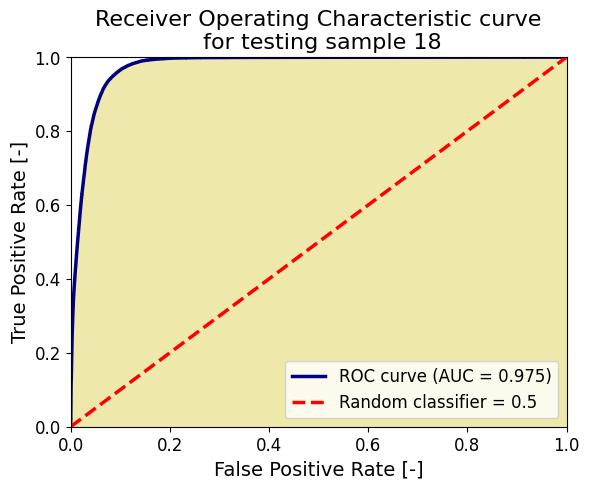

In [22]:
single_roc_curve(model_loss, test_set, sample=18, device=device);

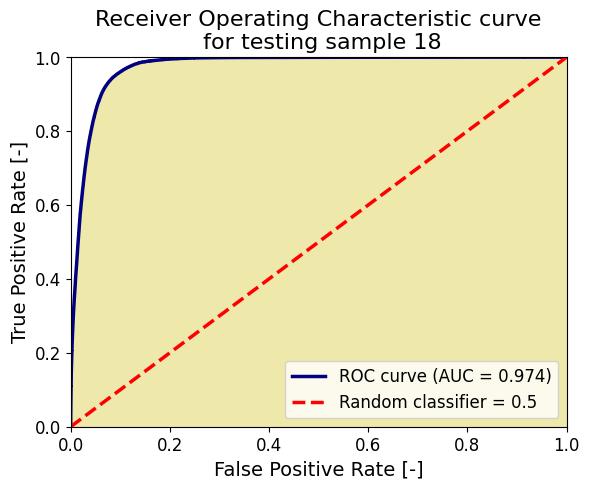

In [23]:
single_roc_curve(model_recall, test_set, sample=18, device=device);

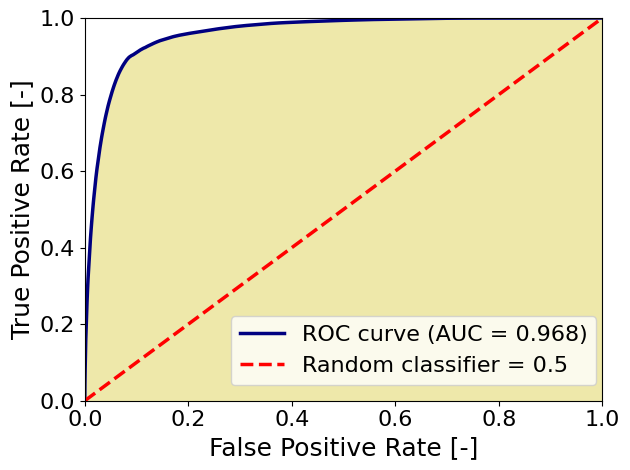

In [24]:
get_total_roc_curve(model_loss, test_set, device=device);

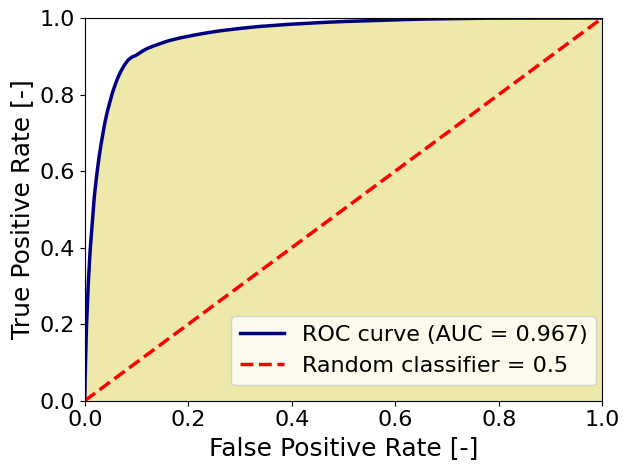

In [25]:
get_total_roc_curve(model_recall, test_set, device=device);

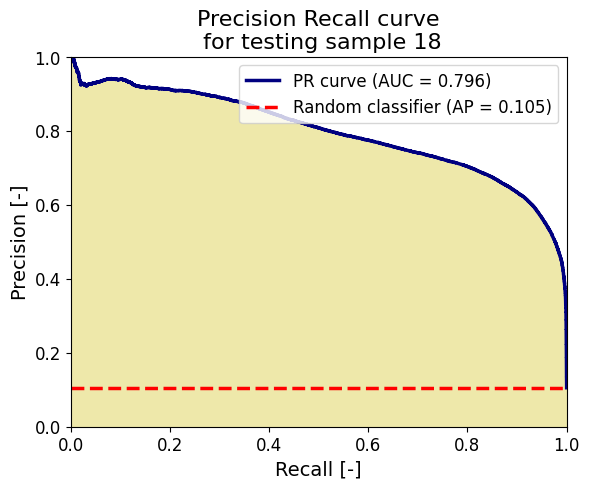

(array([0.10547   , 0.10547021, 0.10547042, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        3.79254764e-05, 1.89627382e-05, 0.00000000e+00]),
 0.7961242525666755,
 tensor(0.1055),
 None)

In [26]:
single_pr_curve(model_loss, test_set, sample=18, device=device)

/workspace/aiaiaik-ramba/postprocessing/metrics.py:189: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


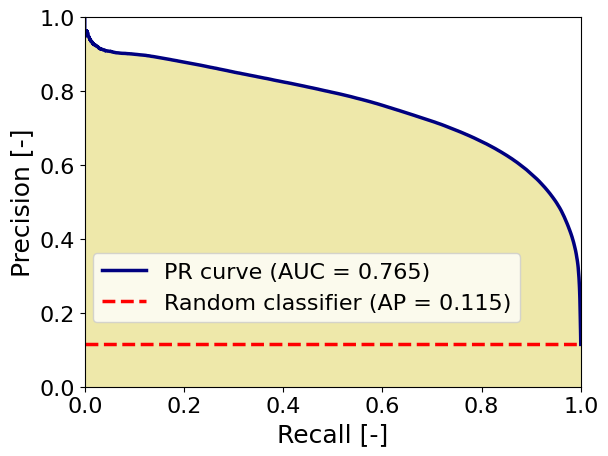

In [28]:
get_total_pr_curve(model_recall, test_set, model_type="max recall", device=device, save_img=False)

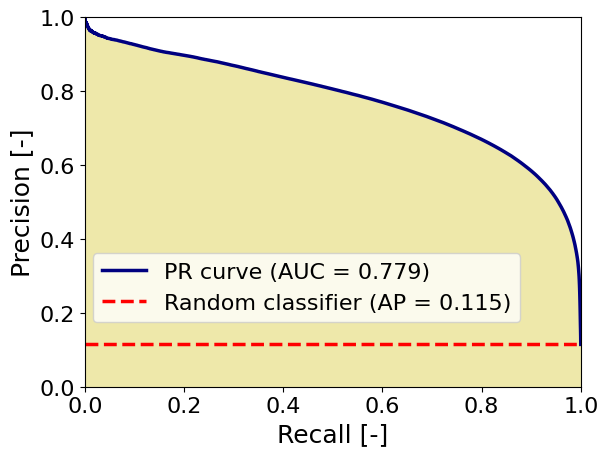

In [29]:
get_total_pr_curve(model_loss, test_set, model_type="min loss", device=device, save_img=False)